# Objectives
- Understand the fundamentals of text clustering.
- Learn how to implement text clustering using Python.
- Explore creative applications of text clustering in various domains.
  
## What is Text Clustering?

Text clustering is an unsupervised machine learning technique that groups texts based on their semantic content, meaning, and relationships. This approach allows us to categorize large volumes of unstructured text efficiently, streamlining data organization and facilitating quick exploratory analysis.

## Why Text Clustering?

While classification methods have been prevalent in recent years, the significance of unsupervised techniques like text clustering is immense and often underappreciated. Here are some use cases of Text Clustering

1. **Initial Exploration Before Classification:** Before delving into complex classification tasks, text clustering offers an intuitive grasp of the data. It helps in understanding not only the task at hand but also the intricacies and complexities inherent in the data.

2. **Innovative Applications**: The unsupervised nature of text clustering opens up a plethora of creative possibilities. It's not just about grouping and classifying documents; it can be used for identifying inaccurate labels, conducting topic modeling, accelerating labeling processes, and much more.

3. **Discovering Patterns with Business Implications:** The insights gained from text clustering extend far beyond academic interest. They have practical applications in numerous business contexts. This includes
   - **Market Research**: By analyzing customer feedback and reviews, text clustering can reveal common themes, helping businesses understand consumer needs and preferences.
   - **Academic Research**: Scholars can use text clustering to categorize research papers, facilitating literature reviews and identifying research gaps.
   - **Healthcare Analysis**: In healthcare, clustering patient records and medical literature can help identify common symptoms or treatment approaches for certain conditions.
   - **Legal Document Organization**: For legal professionals, text clustering aids in organizing case files, legal precedents, and legislation, making it easier to find relevant information.
   - **Issue Identification**: It can pinpoint recurring issues in customer support communications.
   - **Content Strategy**: It aids in identifying new topics for SEO-driven content creation.
   - **Trend Analysis**: It's useful in spotting emerging topics on social media.
   - **Content Management**: It assists in detecting duplicate or similar content.

# Data: ArXiv Articles

In this notebook we will focus on clustering a selection of ArXiv articles in the realms of machine learning and natural language processing. The dataset comprises approximately XXX articles, spanning from XXX to XXX, providing a rich ground for our text clustering exploration.

In [1]:
# check if we are using google colab
from pathlib import Path
import textwrap
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount("/content/drive")
    !pip install datasets transformers bertopic umap hdbscan  openai -U -qq

    base_folder = Path("/content/drive/MyDrive/data")
else:
    base_folder = Path("/home/harpreet/Insync/google_drive_shaannoor/data")

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 103.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.5/158.5 kB 23.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 85.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 9

In [2]:
from pprint import pprint
import torch
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
import joblib
from umap import UMAP
from hdbscan import HDBSCAN
from scipy.cluster import hierarchy as sch
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity


In [3]:
def print_wrap(text, width=80):
    """
    Prints the given text, wrapping lines to a maximum of the specified width (default is 80 characters).

    Args:
    text (str): The text to be printed.
    width (int): The maximum width of a line, in characters.
    """
    wrapper = textwrap.TextWrapper(width=width)
    wrapped_text = wrapper.fill(text)
    print(wrapped_text)

In [4]:
data_folder = base_folder/'datasets/arxiv'
model_folder = base_folder/'models/nlp_fall_2023/clustering/arxiv'
model_folder.mkdir(exist_ok=True, parents=True)
data_folder.mkdir(exist_ok=True, parents=True)


## Import Data

In [5]:
dataset = load_dataset("maartengr/arxiv_nlp")["train"]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

In [6]:
dataset = dataset.shuffle(seed = 42).select(range(1000))

In [7]:
dataset

Dataset({
    features: ['Titles', 'Abstracts', 'Years', 'Categories'],
    num_rows: 1000
})

In [8]:
dataset.features

{'Titles': Value(dtype='string', id=None),
 'Abstracts': Value(dtype='string', id=None),
 'Years': Value(dtype='int64', id=None),
 'Categories': Value(dtype='string', id=None)}

## Extract Meta data

In [9]:
abstracts = dataset["Abstracts"]
years = dataset["Years"]
titles = dataset["Titles"]

# Text Clustering Steps
Text clustering has three main steps

1. Embed documents

2. Reduce dimensionality

3. Cluster embeddings

## Embed Documents

### What is Document Embedding?

Document embedding is the process of converting text data into numerical vectors, known as embeddings. These vectors represent the semantic content of the documents in a high-dimensional space. Each dimension captures some aspect of the document's content, making these vectors extremely useful for various NLP tasks.

### Why are Embeddings Important?

Embeddings are crucial because they transform unstructured text into a structured, numerical form that machine learning algorithms can understand and process. This transformation allows for the analysis of relationships and patterns within the text at a semantic level.

### Why Sentence Transformers are a Good Choice:

Sentence Transformers, a type of language model, are designed to capture the context and meaning of entire sentences or documents, not just individual words. This leads to more meaningful and contextually relevant embeddings.

In [10]:
# We load our model
embedding_model = SentenceTransformer('all-mpnet-base-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [11]:
# The abstracts are converted to vector representations
embeddings = embedding_model.encode(abstracts)

In [12]:
joblib.dump(embeddings,model_folder/'arxiv_nlp_abstract_embeddings')

['/content/drive/MyDrive/data/models/nlp_fall_2023/clustering/arxiv/arxiv_nlp_abstract_embeddings']

In [13]:
embeddings_arxiv = joblib.load(model_folder/'arxiv_nlp_abstract_embeddings')

In [14]:
embeddings_arxiv.shape

(1000, 768)

## Reduce dimensionality
Dimensionality reduction is essential in text clustering for several key reasons:

1. **Curse of Dimensionality**: High-dimensional data, like text embeddings, often suffer from the curse of dimensionality. In such spaces, distances between points (documents) become less meaningful, making it harder to distinguish clusters effectively.

   - **Distance Concentration**: In high-dimensional spaces, the difference between the nearest and farthest points tends to become smaller. Distances between various points converge to a similar value, making it difficult to distinguish between close and far points effectively. This convergence undermines the basic principle of clustering, which relies on distinguishing points based on distances.

   - **Volume of Space Increases Exponentially**: As the number of dimensions increases, the volume of the space increases exponentially. This vast space means that data points are often sparsely distributed, leading to most points being roughly equidistant from each other, which again makes it challenging to identify meaningful clusters.

2. **Computational Efficiency**: Reducing dimensions makes computational processes more efficient. Clustering high-dimensional data can be computationally expensive and time-consuming. Dimensionality reduction alleviates this by simplifying the data structure.

3. **Improved Clustering Performance**: Lower-dimensional spaces can enhance the performance of clustering algorithms. They can more easily identify groupings when the data is not spread across too many dimensions.

4. **Noise Reduction**: Dimensionality reduction helps in filtering out noise and irrelevant features, which might otherwise skew the results of the clustering.
   
5. **Visualization**: It allows for the visualization of clusters in 2D or 3D space, which is not feasible with high-dimensional data. This visualization aids in understanding and interpreting the results of the clustering process.


In summary, dimensionality reduction is crucial for managing the complexity of high-dimensional text data, improving computational efficiency, enhancing clustering performance, reducing noise, and enabling the visualization of clusters.

Dimensionality reduction techniques aim to preserve the global structure of high-dimensional data by finding low-dimensional representations. Well-known methods are **Principal Component Analysis (PCA)** and **Uniform Manifold Approximation**.

### Principal Component Analysis (PCA)

Principal Component Analysis (PCA) is a widely used technique for dimensionality reduction. It works by identifying the axes (principal components) along which the variance in the data is greatest. PCA then projects the data onto these axes, reducing the number of dimensions while retaining as much of the data's variance as possible. This process simplifies the dataset by transforming it into a lower-dimensional space. PCA is linear, meaning it assumes a linear relationship between variables, and is particularly effective in scenarios where the principal components capture a significant portion of the data variance.

### Uniform Manifold Approximation and Projection (UMAP)

Uniform Manifold Approximation and Projection (UMAP) is a relatively newer dimensionality reduction technique that excels in preserving both the local and global structure of the data. Unlike PCA, UMAP is a non-linear technique, making it more adept at handling complex, non-linear relationships within the data. UMAP operates by constructing a high-dimensional graph of the data points and then optimally projecting this graph into a lower-dimensional space. This process tends to preserve the clustering and relationships inherent in the data more effectively than linear methods.

For this pipeline, we are going with UMAP as it tends to handle non-linear relationships and structures a bit better than PCA.

In [15]:
# We instantiate our UMAP model
umap_model = UMAP(n_neighbors=15, n_components=10, min_dist=0.0, metric='cosine', random_state=42)

# We fit and transform our embeddings to reduce them
reduced_embeddings = umap_model.fit_transform(embeddings_arxiv)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


The code snippet above shows the instantiation and use of a UMAP (Uniform Manifold Approximation and Projection) model for dimensionality reduction applied to  `embeddings`. Let's break down the key parameters used in the UMAP model:

1. **`n_neighbors` (15 in this case)**: This parameter determines the number of neighboring points used in the local manifold approximation. In simple terms, `n_neighbors` controls how UMAP balances local versus global structure in the data. A smaller value focuses more on the local structure (making the model more sensitive to local clusters), while a larger value helps to preserve the broader, global structure of the data.

2. **`n_components` (5 in this case)**: This parameter specifies the number of dimensions to which the data should be reduced. Here, `n_components=5` means that the high-dimensional input data (embeddings) will be projected down to a 5-dimensional space. This reduced-dimensional representation is what `reduced_embeddings` will consist of after the transformation. This process is key in simplifying the data and making it more manageable for subsequent analysis, such as clustering.

### How to choose `n_neighbors`:

Choosing the appropriate `n_neighbors` value in UMAP (Uniform Manifold Approximation and Projection) is crucial for achieving optimal clustering results, and it depends on several factors related to your data and the objectives of your analysis. Here are some guidelines to help you decide on the `n_neighbors` value:

1. **Data Size and Density**: For larger datasets, a higher `n_neighbors` value might be necessary to capture the global structure effectively. In contrast, smaller datasets or datasets with denser clusters may benefit from a smaller `n_neighbors` value to focus on local structures.

2. **Intrinsic Data Structure**: Consider the inherent structure of your data. If the data has distinct, well-separated clusters, a smaller `n_neighbors` can help to emphasize these separations. If the data is more uniformly distributed or the clusters are not well-defined, a larger `n_neighbors` can provide a better overall picture.

3. **Clustering Objective**: Determine what you want to achieve with clustering. If you're interested in identifying finer subgroups or more nuanced patterns within the data, a smaller `n_neighbors` might be more appropriate. For broader trends and patterns, a larger value would be more suitable.

4. **Experimentation and Validation**: Often, the best way to choose `n_neighbors` is through experimentation. Try different values and observe how they affect your clustering results. Validate these results using domain knowledge or external metrics to ensure that the clusters make sense in the context of your analysis.

5. **Noise and Outliers**: If your data contains noise or outliers, a larger `n_neighbors` might be better as it can help to mitigate the impact of these anomalies. A smaller `n_neighbors` might make the model too sensitive to such irregularities.

In summary, there's no one-size-fits-all answer for the ideal `n_neighbors` value. It should be chosen based on the specific characteristics of your data, the goals of your analysis, and through a process of experimentation and validation.


### How to choose `n_components`:

The number of components in dimensionality reduction, particularly when using techniques like UMAP or PCA, significantly impacts the clustering process. This parameter, often specified as `n_components`, determines the number of dimensions into which the original high-dimensional data is projected. Here's how the choice of `n_components` affects clustering:

1. **Representation of Variance**: In the context of PCA, `n_components` represents the number of principal components used to capture the variance in the data. A higher number of components means more of the original data's variance is retained, which can lead to more accurate and nuanced clusters. However, too many components might include noise and redundant information, potentially leading to less distinct clusters.

2. **Complexity and Overfitting**: A higher number of components can capture more complex structures in the data, but it also increases the risk of overfitting, especially if the number of data points is not large enough. Overfitting can result in clusters that are too specific to the training data and may not generalize well.

3. **Computational Efficiency**: More components increase the computational complexity of the clustering process. It can lead to longer processing times and higher memory usage. Depending on the computational resources and the size of the dataset, it might be practical to limit the number of components.

4. **Cluster Separability and Interpretability**: With fewer components, the data is projected into a simpler space, which might enhance the separability of clusters by removing less relevant dimensions. However, too few components might oversimplify the data, leading to loss of important information and poorly defined clusters. On the flip side, with more components, clusters might be better defined but harder to interpret due to the increased complexity of the data space.

5. **Visualization**: The number of components also impacts the ability to visualize the data. For visualization purposes, reducing data to 2 or 3 dimensions is common, as it allows for plotting on 2D or 3D graphs. While higher-dimensional spaces might provide more detailed clustering, they cannot be directly visualized and require additional methods to interpret.

In conclusion, choosing the right number of components is a balancing act. It involves considering the complexity and size of your dataset, computational resources, the risk of overfitting, and your specific clustering objectives. Experimentation and validation are often necessary to find the optimal number that strikes a balance between preserving meaningful information and maintaining computational efficiency and interpretability.

In [16]:
reduced_embeddings.shape

(1000, 10)

## Cluster Embeddings

### Overview of three major types of clustering algorithms:

1. **Centroid-Based Clustering (e.g., K-Means)**:
   - **K-Means** is a popular centroid-based clustering algorithm. It works by partitioning the data into a predetermined number of clusters (K).
   - The algorithm iteratively assigns each data point to the nearest centroid (the center of a cluster) and recalculates the centroids based on the current cluster memberships.
   - K-Means is efficient for large datasets but requires the number of clusters to be specified in advance. It works best with spherical clusters and can struggle with complex geometries or varying cluster sizes.
<br><br>
2. **Hierarchical Clustering Methods (e.g., Agglomerative Clustering)**:
   - **Agglomerative Clustering** is a type of hierarchical clustering method that builds clusters in a bottom-up approach. It starts by treating each data point as a single cluster and then successively merges clusters based on a linkage criterion (like minimum distance).
   - It creates a tree of clusters known as a dendrogram, which can be used to decide the number of clusters by cutting the tree at the desired level.
   - Agglomerative clustering is particularly useful for smaller datasets and when the structure of the data is unknown. It can handle non-Euclidean distances and various cluster shapes.
<br><br>
3. **Density-Based Clustering (e.g., HDBSCAN)**:
   - **HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise)** extends DBSCAN, a density-based method, by converting it into a hierarchical clustering algorithm and adding the concept of relative density.
   - HDBSCAN identifies areas of high density and separates them into clusters, while treating low-density points as noise. It doesn't require specifying the number of clusters and is good at handling clusters of varying densities.
   - This method is particularly effective for data with noise and varying densities. It can identify arbitrarily shaped clusters and is less affected by outliers.

Each of these algorithms has its strengths and is suited to different types of data and clustering requirements. K-Means excels in speed and simplicity for large, well-separated data, Agglomerative Clustering offers flexibility and interpretability with hierarchical structures, and HDBSCAN is robust in handling complex, noisy data with clusters of varying shapes and sizes.


### Advantages of  HDBSCAN for Text Clustering
For text clustering, **density-based clustering methods like HDBSCAN** are often more effective compared to centroid-based (like K-Means) or hierarchical methods. The reasons for this suitability are:

1. **Handling of Irregular Shapes**: Text data often forms clusters of irregular shapes due to the complex and nuanced relationships between different pieces of text. Density-based methods like HDBSCAN are adept at identifying clusters of arbitrary shapes, which is crucial for accurately grouping text documents based on their semantic similarity.

2. **Flexibility with Cluster Size and Density**: Text datasets can have clusters of varying sizes and densities. HDBSCAN excels in such environments as it does not assume uniform density across all clusters, unlike methods like K-Means.

3. **Noise Tolerance**: Text data often includes outliers or noise (such as documents that don't fit well into any category). HDBSCAN can distinguish noise from core data points, thus providing cleaner and more meaningful clusters.

4. **No Need to Specify Number of Clusters**: In text clustering, determining the right number of clusters a priori (as required in K-Means) can be challenging. HDBSCAN, however, does not require this specification, as it automatically determines the number of clusters based on data density.

5. **Hierarchical Clustering Insights**: HDBSCAN provides not just a flat clustering solution but also hierarchical clustering information. This aspect can be particularly useful in understanding the layered structure or varying levels of granularity in text data.

While HDBSCAN offers these advantages, the best choice of algorithm can still depend on the specific characteristics of the text data at hand and the particular requirements of the analysis. For some text datasets, especially those that are large and relatively well-structured, algorithms like K-Means or Agglomerative Clustering might still provide useful insights. Therefore, it's often beneficial to experiment with different clustering methods to determine which one works best for your specific data and objectives.

In [17]:
# We instantiate our HDBSCAN model
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom')

# We fit our model and extract the cluster labels
hdbscan_model.fit(reduced_embeddings)
clusters = hdbscan_model.labels_

In [18]:
clusters[0:10]

array([ 4, 10, -1, -1, 10, 10,  7,  2, -1, -1])

In [19]:
clusters.shape

(1000,)

<Axes: xlabel='x', ylabel='y'>

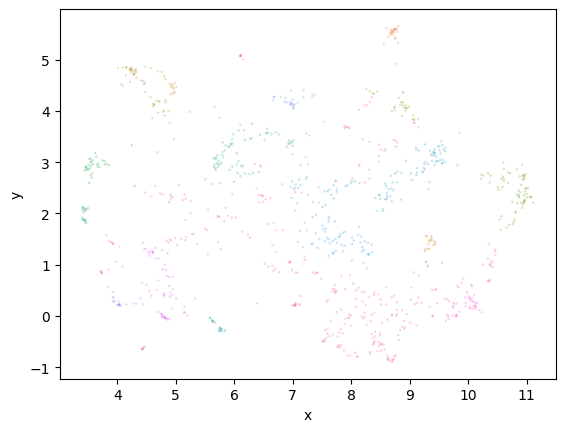

In [20]:

# Reduce 768-dimensional embeddings to 2 dimensions for easier visualization
reduced_embeddings_2 = UMAP(n_neighbors=15, n_components=2,
min_dist=0.0, metric='cosine').fit_transform(embeddings_arxiv)
df = pd.DataFrame(np.hstack([reduced_embeddings_2, clusters.reshape(-1, 1)]),
     columns=["x", "y", "cluster"]).sort_values("cluster")

# Visualize clusters
df.cluster = df.cluster.astype(int).astype(str)
sns.scatterplot(data=df, x='x', y='y', hue='cluster',
   linewidth=0, legend=False, s=3, alpha=0.3)

In [21]:
reduced_embeddings.shape, clusters.shape, np.array(abstracts).shape

((1000, 10), (1000,), (1000,))

In [22]:
df = pd.DataFrame(np.hstack([clusters.reshape(-1, 1), np.array(abstracts).reshape(-1,1)]),
                  columns=["cluster", "abstract"]).sort_values("cluster")


In [23]:
df.head(10)

,cluster,abstract
999,-1,The study explores the effectiveness of the ...
423,-1,"In recent months, Language Models (LMs) have..."
227,-1,We present the Language Interpretability Too...
225,-1,We propose a model to automatically describe...
224,-1,Cognitive psychologists have documented that...
652,-1,Entity resolution aims at resolving repeated...
222,-1,Sentiment analysis of user-generated reviews...
221,-1,Interactive Task Learning (ITL) concerns lea...
655,-1,In this paper we implement and compare 7 dif...
426,-1,Word embeddings have been shown adept at cap...


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 999 to 241
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   cluster   1000 non-null   object
 1   abstract  1000 non-null   object
dtypes: object(2)
memory usage: 23.4+ KB


In [25]:
df.value_counts('cluster')

cluster
-1    292
10     83
9      80
7      70
4      67
2      66
14     54
13     53
15     48
5      33
3      30
1      22
11     22
0      22
12     20
6      19
8      19
Name: count, dtype: int64

In [26]:
unique_clusters = np.unique(clusters)
unique_clusters.shape

(17,)

In [27]:
unique_clusters

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

Let us check the abstracts of one particular Cluster

In [28]:
for index in np.where(clusters==1)[0][-10:]:
    print(abstracts[index])

  Despite the impressive performance achieved by pre-trained
language-and-vision models in downstream tasks, it remains an open question
whether this reflects a proper understanding of image-text interaction. In this
work, we explore to what extent they handle basic linguistic constructions --
active-passive voice, coordination, and relative clauses -- that even preschool
children can typically master. We present BLA, a novel, automatically
constructed benchmark to evaluate multimodal models on these Basic Language
Abilities. We show that different types of Transformer-based systems, such as
CLIP, ViLBERT, and BLIP2, generally struggle with BLA in a zero-shot setting,
in line with previous findings. Our experiments, in particular, show that most
of the tested models only marginally benefit when fine-tuned or prompted with
construction-specific samples. Yet, the generative BLIP2 shows promising
trends, especially in an in-context learning setting. This opens the door to
using BLA not on